# Support Vector Machines

## Step 0: Project Setup

### Importing the Libraries 

In [95]:
# Scikit-learn utilities
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score

### Importing the Dataset

NOTE: THERE IS ERROR IN UTILS.PY, FOR ONE OF THE FEATURES -> TELL CHARLIE TO FIX FIRST

In [103]:
import sys
import os
import pandas as pd

# To allow for importing of 'utils' module from parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

from utils import import_data

dataset_path = "../data"
dataset_version = "automated-v1.0"

automated_dataset = import_data(dataset_path, dataset_version)

automated_dataframe = automated_dataset["dataframe"]

X = automated_dataframe.iloc[:, :-1]  # All columns except the last one
y = automated_dataframe.iloc[:, -1]  # The last column

# Dropped upload times because pre-processing too much work (calculating std)
X = X.drop(columns=['mediaUpload_times'])

## Step 1: Data Preprocessing & Scaling

### Aggregating Non-numeric Data

Because some of the features have non-numeric values (lists), we should first either aggregate their values into a single value, or just remove them all together.

In [104]:
# Aggregate Features with non-numeric values

X['media_comment_numbers'] = X['media_comment_numbers'].apply(lambda i: np.mean(i) if len(i) > 0 else 0)
X['media_hashtag_numbers'] = X['media_hashtag_numbers'].apply(lambda i: np.mean(i) if len(i) > 0 else 0)
X['media_like_numbers'] = X['media_like_numbers'].apply(lambda i: np.mean(i) if len(i) > 0 else 0)

# binary features to be summed
X['media_comments_are_disabled'] = X['media_comments_are_disabled'].apply(np.sum)
X['media_has_location_info'] = X['media_has_location_info'].apply(np.sum)

### Splitting the Data

In [105]:
# Splitting the dataset (20% Testing, 20% Validating, 60% Training)

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,   
    test_size = 0.2, random_state=42, shuffle=True, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, 
    test_size = 0.25, random_state=42, shuffle=True, stratify=y_train_val
)

print(np.unique(y_train, return_counts=True))

# Check if splits are correct
print('X_train:' + str(X_train.shape))
print('y_train:' + str(y_train.shape))
print('X_val: \t'  + str(X_val.shape))
print('y_val: \t'  + str(y_val.shape))
print('X_test: '  + str(X_test.shape))
print('y_test: '  + str(y_test.shape))

(array([0, 1], dtype=int64), array([420, 420], dtype=int64))
X_train:(840, 15)
y_train:(840,)
X_val: 	(280, 15)
y_val: 	(280,)
X_test: (280, 15)
y_test: (280,)


### Scaling the Data

In [106]:
# Scale Input Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(X_train[0:2])

[[-0.47053333 -0.04059714  3.32524774 -0.96720415 -0.66580701 -0.03792806
  -0.05718309  1.64736904  1.05241263 -0.33696283 -0.0172352  -0.08145478
  -0.48359663 -0.70042572  0.00538244]
 [-0.10630055 -0.05354655 -0.72847212 -0.96720415 -0.66580701 -0.03784087
  -0.05571236 -1.12061692  0.27170029 -0.33696283 -0.22427415 -0.08145478
  -0.30914672 -0.54908037 -0.06312787]]


## Step 2: Data Transformations

We will be training on the following kernels:
- **Linear**
- **Polynomial (Degree = 3)**
- **RBF**

Training Function

In [132]:
def train_svm(kernel, c_values, degree=1):

    table_results = []
    train_accuracies = []
    val_accuracies = []
    for c in c_values:
        # initialize svc
        svm_linear = svm.SVC(kernel=kernel, C=c, degree=degree)

        # train model / fit to training data
        svm_linear.fit(X_train, y_train)

        # train accuracy
        train_prediction = svm_linear.predict(X_train)
        train_accuracy = np.mean(train_prediction == y_train)
        train_accuracies.append(train_accuracy)

        # validation accuracy
        val_prediction = svm_linear.predict(X_val)
        val_accuracy = np.mean(val_prediction == y_val)
        val_accuracies.append(val_accuracy)

        # Precision
        train_precision = precision_score(y_train, train_prediction, zero_division=0)
        val_precision = precision_score(y_val, val_prediction, zero_division=0)
        
        # Recall
        train_recall = recall_score(y_train, train_prediction)
        val_recall = recall_score(y_val, val_prediction)

        table_results.append({
            'C-value': c,
            'Train Accuracy': train_accuracy,
            'Validation Accuracy': val_accuracy,
            'Train Precision': train_precision,
            'Validation Precision': val_precision,
            'Train Recall': train_recall,
            'Validation Recall': val_recall
        })

    print('Degree: ', degree)

    # Convert to DataFrame
    result = pd.DataFrame(table_results)

    # Display
    print(result)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(c_values, train_accuracies, marker='o', label='Train Accuracy')
    plt.plot(c_values, val_accuracies, marker='o', label='Validation Accuracy')
    plt.xscale('log')  # Because C is usually plotted on a log scale
    plt.xlabel('C (Regularization Strength)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Regularization (C) for SVM')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [143]:
def train_svm_by_degree(c_value, degrees):
    train_accuracies = []
    val_accuracies = []

    for degree in degrees:
        # Initialize SVM with polynomial kernel
        svm_poly = svm.SVC(kernel='poly', C=c_value, degree=degree, random_state=42)

        # Train the model
        svm_poly.fit(X_train, y_train)

        # Training accuracy
        train_prediction = svm_poly.predict(X_train)
        train_accuracy = np.mean(train_prediction == y_train)
        train_accuracies.append(train_accuracy)

        # Validation accuracy
        val_prediction = svm_poly.predict(X_val)
        val_accuracy = np.mean(val_prediction == y_val)
        val_accuracies.append(val_accuracy)

        print(f"Degree: {degree}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Plot the results
    plt.figure(figsize=(8, 6))
    plt.plot(degrees, train_accuracies, marker='o', label='Train Accuracy')
    plt.plot(degrees, val_accuracies, marker='o', label='Validation Accuracy')
    plt.xlabel('Degree of Polynomial Kernel')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs Degree (C={c_value})')
    plt.legend()
    plt.grid(True)
    plt.show()

Inverse Regularization Values (C)
- Smaller C increases regularization -> less risk of overfitting & more simple
- Larger C decreases regularization -> more risk of overfitting & more complex

In [112]:
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

### Linear Kernel

Degree:  1
     C-value  Train Accuracy  Validation Accuracy  Train Precision  \
0     0.0001        0.645238             0.653571         0.991935   
1     0.0010        0.854762             0.850000         0.938235   
2     0.0100        0.884524             0.900000         0.917313   
3     0.1000        0.900000             0.910714         0.928571   
4     1.0000        0.911905             0.910714         0.928218   
5    10.0000        0.920238             0.928571         0.933661   
6   100.0000        0.926190             0.917857         0.952020   
7  1000.0000        0.923810             0.928571         0.945000   

   Validation Precision  Train Recall  Validation Recall  
0              1.000000      0.292857           0.307143  
1              0.971154      0.759524           0.721429  
2              0.944444      0.845238           0.850000  
3              0.960000      0.866667           0.857143  
4              0.952756      0.892857           0.864286  
5   

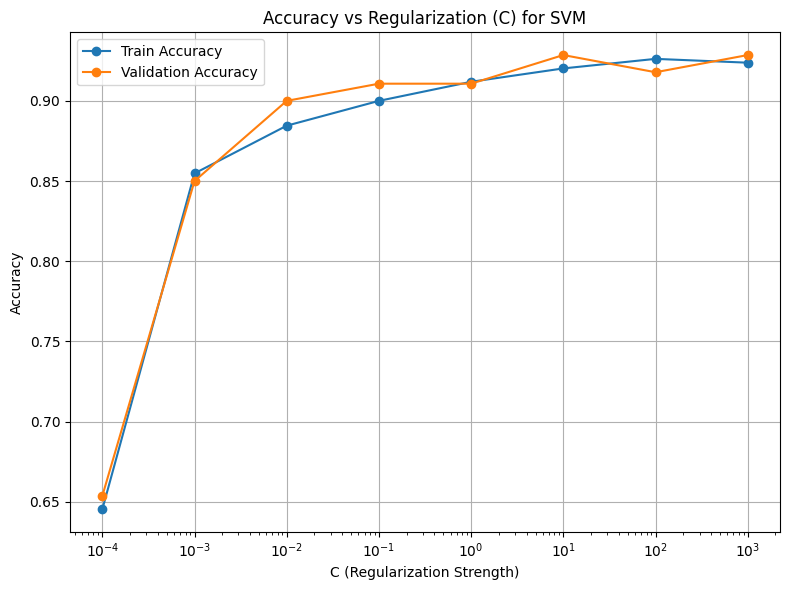

In [133]:
train_svm('linear', c_values)

### Polynomial Kernel

Degree:  2
     C-value  Train Accuracy  Validation Accuracy  Train Precision  \
0     0.0001        0.501190             0.500000         0.500596   
1     0.0010        0.501190             0.500000         0.500596   
2     0.0100        0.529762             0.521429         1.000000   
3     0.1000        0.684524             0.667857         0.964072   
4     1.0000        0.828571             0.825000         0.887640   
5    10.0000        0.876190             0.853571         0.891089   
6   100.0000        0.920238             0.889286         0.923261   
7  1000.0000        0.942857             0.892857         0.960396   

   Validation Precision  Train Recall  Validation Recall  
0              0.500000      1.000000           1.000000  
1              0.500000      1.000000           1.000000  
2              1.000000      0.059524           0.042857  
3              1.000000      0.383333           0.335714  
4              0.902655      0.752381           0.728571  
5   

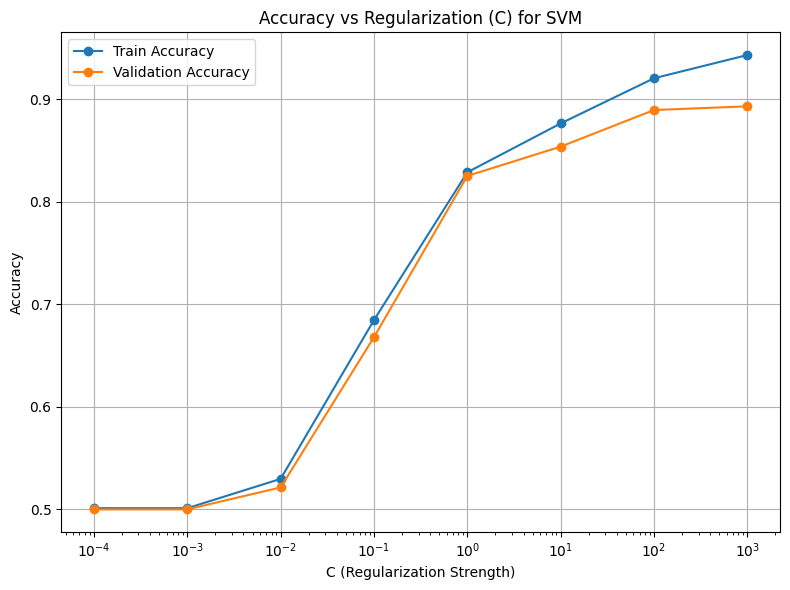

Degree:  3
     C-value  Train Accuracy  Validation Accuracy  Train Precision  \
0     0.0001        0.501190             0.500000         0.500596   
1     0.0010        0.513095             0.507143         1.000000   
2     0.0100        0.554762             0.535714         1.000000   
3     0.1000        0.747619             0.710714         0.990566   
4     1.0000        0.876190             0.839286         0.956647   
5    10.0000        0.926190             0.867857         0.954315   
6   100.0000        0.957143             0.907143         0.968293   
7  1000.0000        0.977381             0.860714         0.995062   

   Validation Precision  Train Recall  Validation Recall  
0              0.500000      1.000000           1.000000  
1              1.000000      0.026190           0.014286  
2              1.000000      0.109524           0.071429  
3              1.000000      0.500000           0.421429  
4              0.979798      0.788095           0.692857  
5   

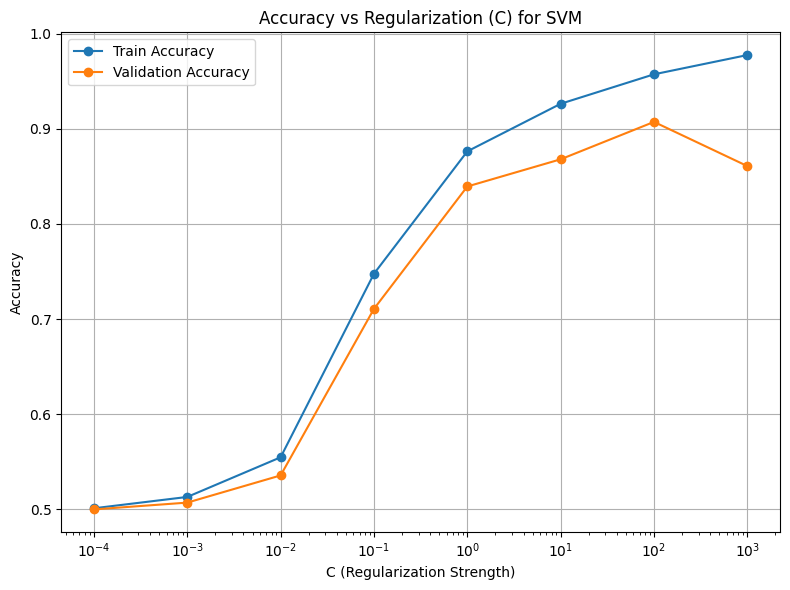

Degree:  4
     C-value  Train Accuracy  Validation Accuracy  Train Precision  \
0     0.0001        0.501190             0.500000         0.500596   
1     0.0010        0.513095             0.510714         1.000000   
2     0.0100        0.541667             0.521429         1.000000   
3     0.1000        0.627381             0.596429         1.000000   
4     1.0000        0.754762             0.710714         0.995370   
5    10.0000        0.866667             0.817857         0.972393   
6   100.0000        0.934524             0.867857         0.979003   
7  1000.0000        0.978571             0.850000         0.990244   

   Validation Precision  Train Recall  Validation Recall  
0              0.500000      1.000000           1.000000  
1              1.000000      0.026190           0.021429  
2              1.000000      0.083333           0.042857  
3              1.000000      0.254762           0.192857  
4              1.000000      0.511905           0.421429  
5   

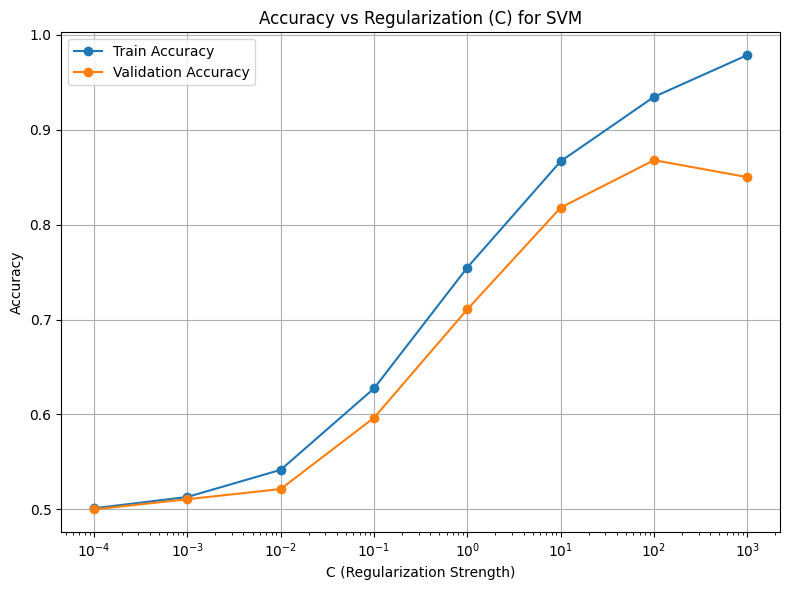

Degree:  5
     C-value  Train Accuracy  Validation Accuracy  Train Precision  \
0     0.0001        0.505952             0.507143         1.000000   
1     0.0010        0.519048             0.514286         1.000000   
2     0.0100        0.550000             0.525000         1.000000   
3     0.1000        0.627381             0.596429         1.000000   
4     1.0000        0.739286             0.696429         0.995074   
5    10.0000        0.851190             0.775000         0.980456   
6   100.0000        0.915476             0.850000         0.978082   
7  1000.0000        0.967857             0.857143         0.990025   

   Validation Precision  Train Recall  Validation Recall  
0              1.000000      0.011905           0.014286  
1              1.000000      0.038095           0.028571  
2              1.000000      0.100000           0.050000  
3              1.000000      0.254762           0.192857  
4              1.000000      0.480952           0.392857  
5   

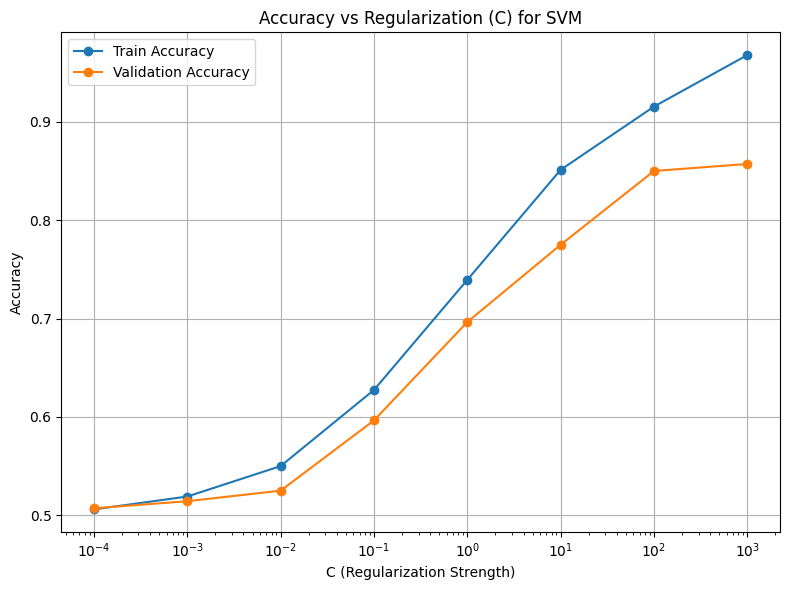

Degree:  6
     C-value  Train Accuracy  Validation Accuracy  Train Precision  \
0     0.0001        0.510714             0.507143         1.000000   
1     0.0010        0.526190             0.517857         1.000000   
2     0.0100        0.555952             0.521429         1.000000   
3     0.1000        0.616667             0.571429         1.000000   
4     1.0000        0.697619             0.657143         1.000000   
5    10.0000        0.792857             0.717857         0.984252   
6   100.0000        0.882143             0.778571         0.993846   
7  1000.0000        0.933333             0.850000         0.994565   

   Validation Precision  Train Recall  Validation Recall  
0              1.000000      0.021429           0.014286  
1              1.000000      0.052381           0.035714  
2              1.000000      0.111905           0.042857  
3              1.000000      0.233333           0.142857  
4              1.000000      0.395238           0.314286  
5   

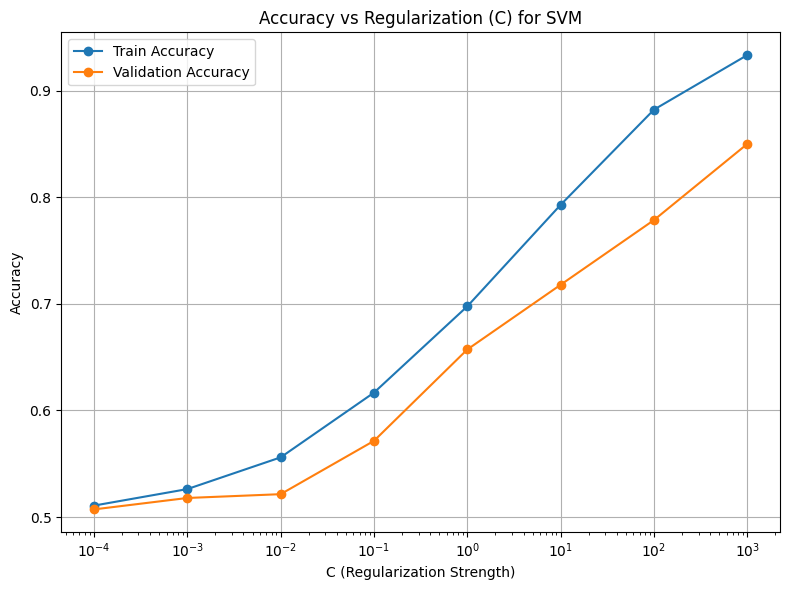

Degree:  7
     C-value  Train Accuracy  Validation Accuracy  Train Precision  \
0     0.0001        0.514286             0.514286         1.000000   
1     0.0010        0.533333             0.517857         1.000000   
2     0.0100        0.560714             0.532143         1.000000   
3     0.1000        0.614286             0.564286         1.000000   
4     1.0000        0.689286             0.653571         1.000000   
5    10.0000        0.763095             0.707143         0.991111   
6   100.0000        0.857143             0.750000         0.993421   
7  1000.0000        0.905952             0.800000         0.991354   

   Validation Precision  Train Recall  Validation Recall  
0              1.000000      0.028571           0.028571  
1              1.000000      0.066667           0.035714  
2              1.000000      0.121429           0.064286  
3              1.000000      0.228571           0.128571  
4              1.000000      0.378571           0.307143  
5   

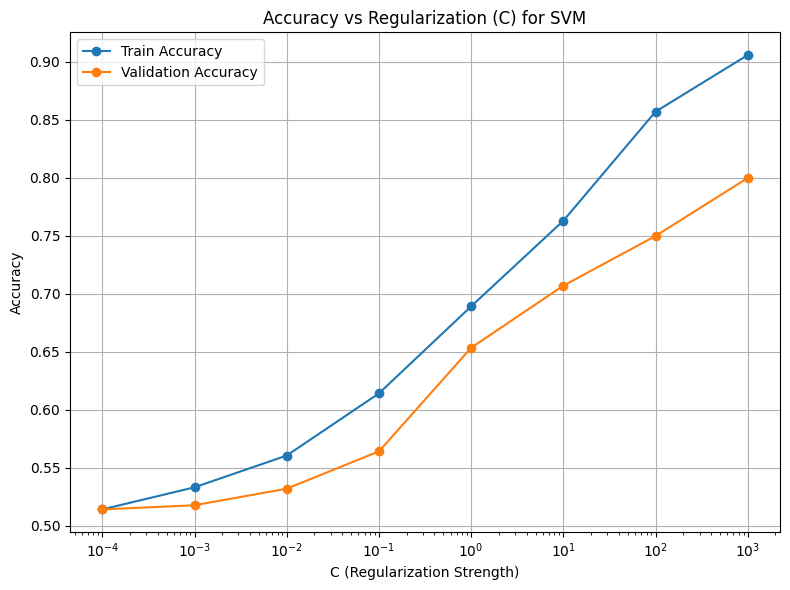

Degree:  8
     C-value  Train Accuracy  Validation Accuracy  Train Precision  \
0     0.0001        0.519048             0.514286         1.000000   
1     0.0010        0.535714             0.517857         1.000000   
2     0.0100        0.563095             0.532143         1.000000   
3     0.1000        0.611905             0.560714         1.000000   
4     1.0000        0.675000             0.625000         1.000000   
5    10.0000        0.739286             0.689286         1.000000   
6   100.0000        0.817857             0.721429         0.996283   
7  1000.0000        0.885714             0.764286         0.996933   

   Validation Precision  Train Recall  Validation Recall  
0              1.000000      0.038095           0.028571  
1              1.000000      0.071429           0.035714  
2              1.000000      0.126190           0.064286  
3              1.000000      0.223810           0.121429  
4              1.000000      0.350000           0.250000  
5   

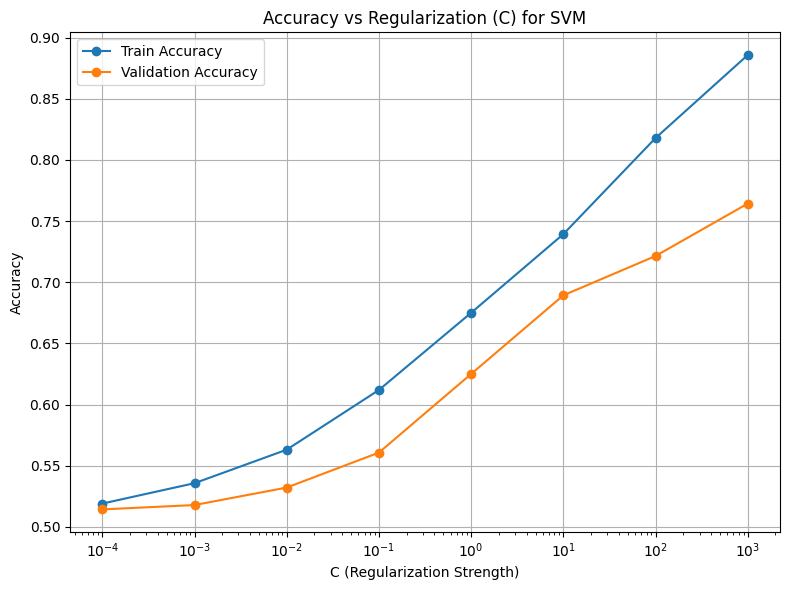

Degree:  9
     C-value  Train Accuracy  Validation Accuracy  Train Precision  \
0     0.0001        0.525000             0.514286         1.000000   
1     0.0010        0.540476             0.517857         1.000000   
2     0.0100        0.566667             0.532143         1.000000   
3     0.1000        0.611905             0.550000         1.000000   
4     1.0000        0.666667             0.610714         1.000000   
5    10.0000        0.721429             0.682143         1.000000   
6   100.0000        0.798810             0.700000         0.996047   
7  1000.0000        0.865476             0.732143         0.993569   

   Validation Precision  Train Recall  Validation Recall  
0              1.000000      0.050000           0.028571  
1              1.000000      0.080952           0.035714  
2              1.000000      0.133333           0.064286  
3              1.000000      0.223810           0.100000  
4              1.000000      0.333333           0.221429  
5   

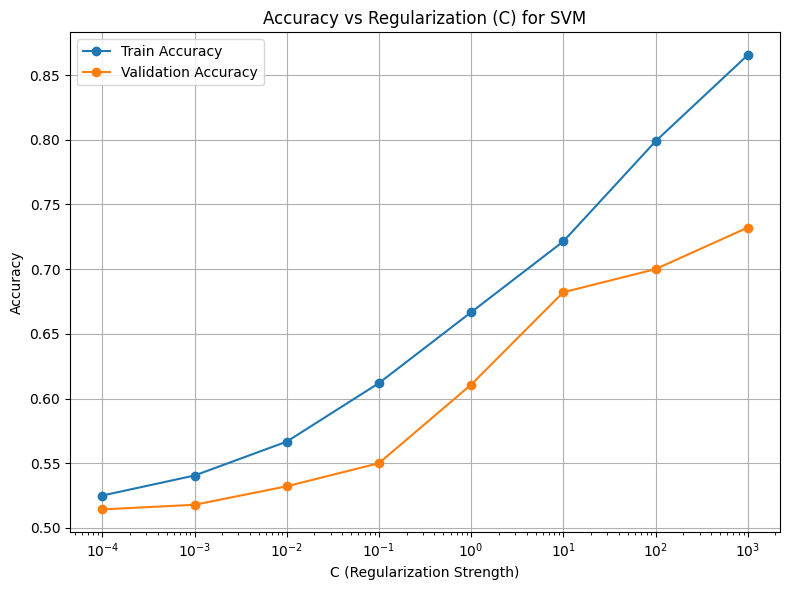

Degree: 2, Train Accuracy: 0.9202, Validation Accuracy: 0.8893
Degree: 3, Train Accuracy: 0.9571, Validation Accuracy: 0.9071
Degree: 4, Train Accuracy: 0.9345, Validation Accuracy: 0.8679
Degree: 5, Train Accuracy: 0.9155, Validation Accuracy: 0.8500
Degree: 6, Train Accuracy: 0.8821, Validation Accuracy: 0.7786
Degree: 7, Train Accuracy: 0.8571, Validation Accuracy: 0.7500
Degree: 8, Train Accuracy: 0.8179, Validation Accuracy: 0.7214
Degree: 9, Train Accuracy: 0.7988, Validation Accuracy: 0.7000


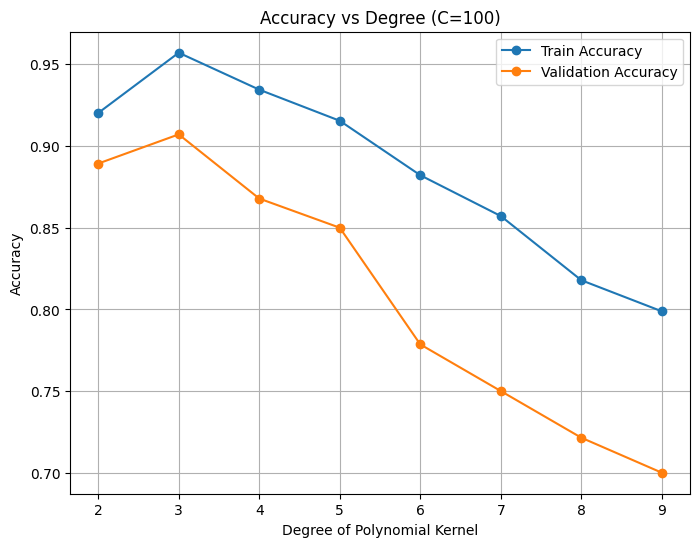

In [ ]:

# ------------------ Relationship between c-value and Accuracy --------------------------

# Goal: Find best c-value

# Degree = 2
train_svm('poly', c_values, 2)

# Degree = 3
train_svm('poly', c_values, 3)

# Degree = 4
train_svm('poly', c_values, 4)

# Degree = 5
train_svm('poly', c_values, 5)

# Degree = 6
train_svm('poly', c_values, 6)

# Degree = 7
train_svm('poly', c_values, 7)

# Degree = 8
train_svm('poly', c_values, 8)

# Degree = 9
train_svm('poly', c_values, 9)


#------------------- Relationship between degree and Accuracy --------------------------

# Goal: Use best c-value to find best degree through Degree vs. Train and Validate Accuracy

degrees = [2,3,4,5,6,7,8,9]
train_svm_by_degree(c_values[6], degrees)


# FINAL CONCLUSION
# -> c = 100 generates highest validation accuracy along with degree = 3 

### Radial Basis Function (RBF) Kernel

Degree:  9
     C-value  Train Accuracy  Validation Accuracy  Train Precision  \
0     0.0001        0.865476             0.835714         0.896641   
1     0.0010        0.865476             0.835714         0.896641   
2     0.0100        0.865476             0.860714         0.877150   
3     0.1000        0.889286             0.903571         0.890215   
4     1.0000        0.920238             0.921429         0.937965   
5    10.0000        0.948810             0.925000         0.954217   
6   100.0000        0.970238             0.907143         0.980535   
7  1000.0000        0.989286             0.900000         1.000000   

   Validation Precision  Train Recall  Validation Recall  
0              0.905172      0.826190           0.750000  
1              0.905172      0.826190           0.750000  
2              0.897638      0.850000           0.814286  
3              0.937984      0.888095           0.864286  
4              0.968254      0.900000           0.871429  
5   

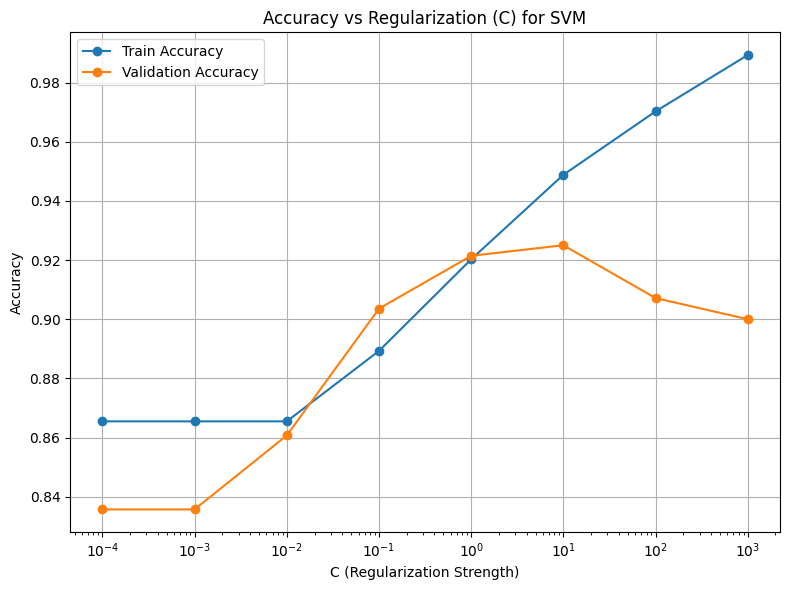

In [ ]:
train_svm('rbf', c_values)

## Step 3: Binary Classification Using the Pegasos Algorithm

### SVM Objective Function

$\min \lambda/2 \lVert {\bf w}\rVert_2^2 + \sum_{i=1}^N\max(0,1-y^{(i)}({\bf w}^T{\bf x}^{(i)}+w_0)$ where $w_0=0$.  You don't need to include $w_0$ in your objective function.

In [78]:
def svm_objective(w, X, y, lambda1=.1):

    regularization_term = (lambda1 / 2) * np.dot(w, w)

    hinge_loss = np.maximum(0, 1 - y * np.dot(X,w))

    average_loss = np.mean(hinge_loss)

    result = regularization_term + average_loss
    
    return result

### Pegasos Algorithm

$
\text{if } y^{(i)}({\bf w}^T{\bf x}^{(i)}\ge 1)  \\ \\
$

$
\phantom{abcd} {\bf w} = {\bf w}-\alpha\lambda {\bf w}\\ \\
$

$
\text{else }  \\ \\
$

$
\phantom{abcd} {\bf w} = {\bf w}-\alpha(\lambda {\bf w}-y^{(i)}{\bf x}^{(i)}) 
$

In [79]:
# stochastic sub-gradient descent
def pegasos(X_train, y_train, lambda1=0.08, num_iters = 3):

    # Hyperparameters: threshold, lambda1
    
    # parameters
    N = X_train.shape[0]
    d = X_train.shape[1]

    t = 0
    # Initial weight vector
    w = np.ones((d,))

    for iter in range(num_iters):
        # Calculate and print the objective value
        #print('Iteration %d. J: %.6f' % (iter, svm_objective(w, X_train, y_train)))

        for i in range (N):
            t = t + 1
            # Complete the following code to find w. This will require several lines of code.
            alpha = 1 / (lambda1 * t)    # learning rate

            if y_train[i] * np.dot(X_train[i], w) > 1:
                w = w - (alpha * lambda1 * w)            
            else:
                w = w - alpha * (lambda1 * w - y_train[i] * X_train[i])
        
    return w

### Train the binary classifiers using the Pegasos Algorithm

In [83]:
y_train = np.where(y_train == 1, 1, -1)
y_val = np.where(y_val == 1, 1, -1)

lambda1 = 0.01
num_iters = 1000

w = pegasos(X_train, y_train, lambda1, num_iters)

predictions = np.where(np.dot(X_val, w) >= 0, 1, -1)

accuracy = np.mean(predictions == y_val)
print('Validation Accuracy: ', accuracy)

Validation Accuracy:  0.8964285714285715
